In [ ]:
import polars as pl
import json
import shap
import numpy as np
from great_tables import GT, md, html

from catboost import CatBoostRegressor,CatBoostClassifier, Pool

from sklearn.metrics import mean_poisson_deviance

import mlflow
from mlflow.models import infer_signature

from utils.utils import define_categorical_columns, define_continuous_columns
from utils.modelling_utils import assign_split, create_modelling_data



In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [3]:
data_path = './processed-data/frequency_set.parquet'
frequency = pl.read_parquet(data_path)

In [4]:
with open('./config/frequency_config.json', 'r') as f:
    config = json.load(f)

In [5]:
features = config.get('features')

In [ ]:
categorical_features = define_categorical_columns(frequency, features)
continuous_features = define_continuous_columns(features, categorical_features)

In [7]:
target = config.get('target')
exposure = config.get('exposure')
split = config.get('split')

In [8]:
frequency = assign_split(frequency, split)

In [9]:
train, X_train, y_train, log_exposure_train = create_modelling_data(frequency, features, 'Group', 'Train', target, exposure)
test, X_test, y_test, log_exposure_test = create_modelling_data(frequency, features, 'Group', 'Test', target, exposure)
holdout, X_holdout, y_holdout, log_exposure_holdout = create_modelling_data(frequency, features, 'Group', 'Holdout', target, exposure)

train_pool = Pool(X_train, label=y_train, cat_features=categorical_features, baseline = log_exposure_train)
test_pool = Pool(X_test, label=y_test, cat_features=categorical_features, baseline = log_exposure_test)
holdout_pool = Pool(X_holdout, label=y_holdout, cat_features=categorical_features, baseline = log_exposure_holdout)

In [10]:

params = config.get('gbm_params').get('learning_params')
num_round = config.get('gbm_params').get('num_rounds')
early_stopping_rounds = config.get('gbm_params').get('early_stopping_rounds')

FrequencyModel = CatBoostRegressor(**params)
FrequencyModel.fit(train_pool, eval_set=[test_pool], early_stopping_rounds=early_stopping_rounds)

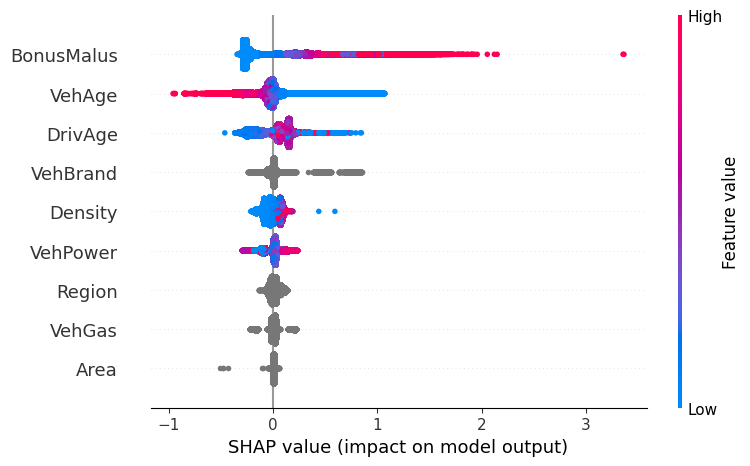

In [11]:
explainer = shap.TreeExplainer(FrequencyModel)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

In [12]:
predictions = FrequencyModel.predict(holdout_pool)
holdout = (
    holdout.with_columns(ClaimCountPrediction = pl.Series(predictions))
)

actuals = holdout.select('ClaimCount').to_numpy().ravel()
poisson_dev = mean_poisson_deviance(actuals, predictions)

In [13]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

mlflow.set_experiment("Frequency GBM")

# Start an MLflow run
with mlflow.start_run():
  # Log the hyperparameters
  mlflow.log_params(params)

  # Log the loss metric
  mlflow.log_metric("poisson_deviance", poisson_dev)

  # Set a tag that we can use to remind ourselves what this run was for
  mlflow.set_tag("Training Info", "Basic GBM for frequency")

  mlflow.set_tag("features_used", ",".join(features))
  mlflow.set_tag("data_used", data_path)


  # Infer the model signature
  signature = infer_signature(X_holdout, predictions)

  # Log the model
  model_info = mlflow.catboost.log_model(
      cb_model=FrequencyModel,
      name="catboost_frequency_model",
      signature=signature,
      input_example=X_holdout,
      registered_model_name="catboost_frequency_model",
  )

2025/08/31 08:14:26 INFO mlflow.tracking.fluent: Experiment with name 'Frequency GBM' does not exist. Creating a new experiment.
2025/08/31 08:14:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Successfully registered model 'catboost_frequency_model'.
2025/08/31 08:14:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: catboost_frequency_model, version 1
Created version '1' of model 'catboost_frequency_model'.


🏃 View run orderly-lynx-3 at: http://127.0.0.1:8080/#/experiments/186526967180956706/runs/15cf648a97c44daba0e4942ceddb9f0b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/186526967180956706


In [14]:
poisson_dev

0.3018340304736188

In [15]:
holdout.write_parquet('./processed-data/holdout_frequency_predictions.parquet')

In [16]:
model_name = "catboost_frequency_model"
model_version = "latest"

# Load the model from the Model Registry
model_uri = f"models:/{model_name}/{model_version}"
model = mlflow.catboost.load_model(model_uri)

: 

: 